# Gibss sampling

##  Example for a bivariate normal distribution

In [1]:
using Distributions
using CairoMakie
using Random

Lets define a custom function to sample from a binomial distribution.

In [2]:
function gibbs_binormal(ρ::Float64, m::Int, initial::Vector)
    samples = zeros(m, 2)

    # initial values
    x1 = initial[1]
    x2 = initial[2]

    # conditional distributions
    for i = 1:m
        x1 = rand(Normal(ρ * x2, sqrt(1-ρ^2)))
        x2 = rand(Normal(ρ * x1, sqrt(1-ρ^2)))
        samples[i, :] = [x1, x2]
    end

    return samples

end

gibbs_binormal (generic function with 1 method)

We can see how the algorithm works

In [3]:
Random.seed!(10)
initial = [0, 0]
samples = gibbs_binormal(0.5, 20, initial)
samples = vcat(transpose(initial), samples)

21×2 Matrix{Float64}:
  0.0        0.0
  0.295364   0.100847
  0.458671   0.0318495
 -0.726577  -1.13155
  0.780604   0.784371
 -0.601151   0.440396
  0.833546   0.333393
  0.230066   0.0780238
 -0.890849  -0.372416
 -1.80207   -0.207705
  ⋮         
  0.367222  -1.37373
 -0.681063  -1.00245
 -0.196687  -0.517821
 -0.727849  -0.355622
  0.238041  -1.05364
  0.530736  -0.496953
 -1.03963   -0.773643
 -1.51436    0.019628
 -0.857625   0.725582

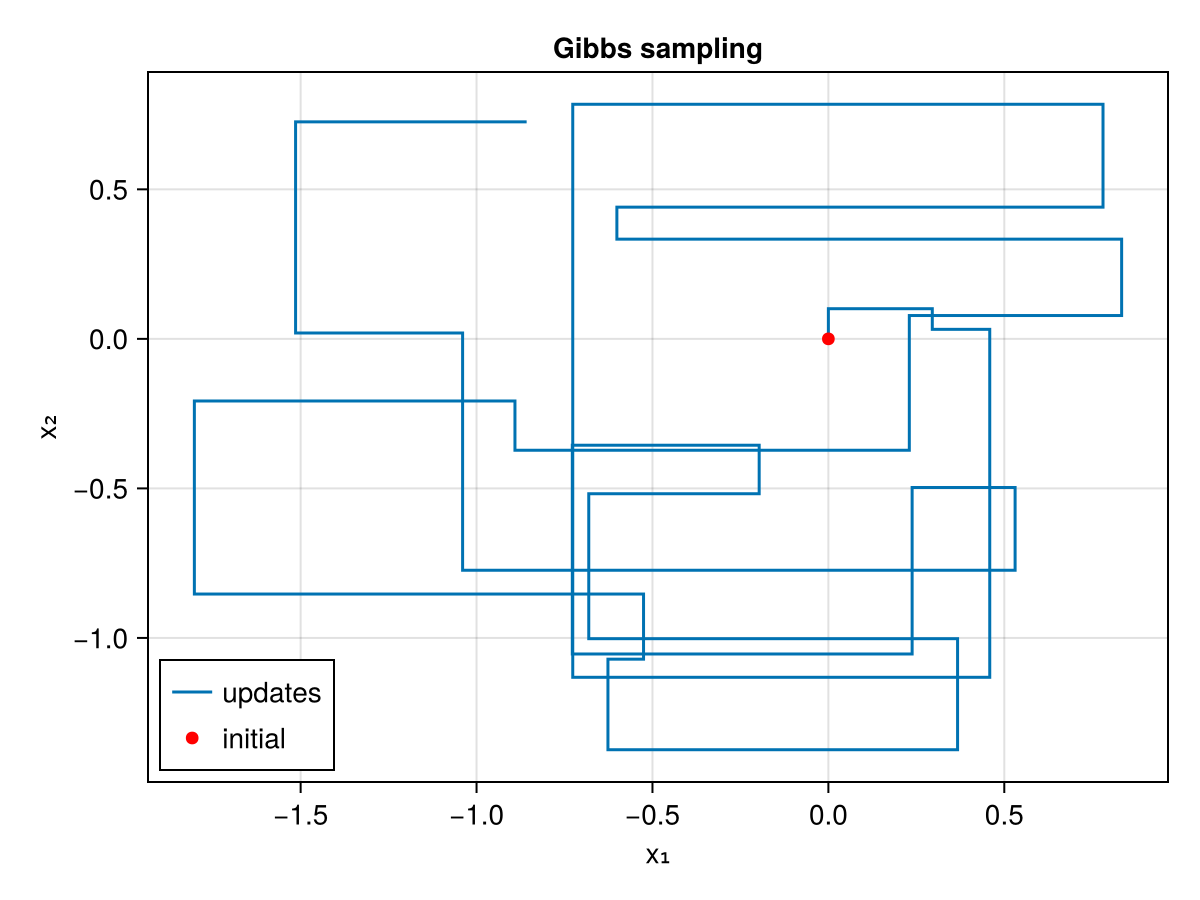

In [4]:
axis_args = (title = "Gibbs sampling", xlabel = "x₁", ylabel = "x₂")
fig = stairs(samples[:, 1], samples[:, 2], label = "updates", axis = axis_args)
scatter!([initial[1]], [initial[2]], color = :red, label = "initial")
axislegend(position = :lb)
fig
# save("data/figures/06-gibbs-bivariate-algorithm.png")

What about the burnin?

In [5]:
initial = [5, 5]
samples = gibbs_binormal(0.5, 100, initial)
samples = vcat(transpose(initial), samples)

101×2 Matrix{Float64}:
  5.0          5.0
  2.68151     -0.124178
 -1.01554     -0.220685
  0.439576    -0.42924
  1.0299       0.675781
  0.625016     0.281295
  0.109074     0.648107
 -0.710088    -0.341435
  0.652368    -0.0337818
  1.1243       0.346758
  ⋮           
  0.281512    -1.33333
 -1.07809     -0.130009
 -0.241171    -0.0757089
 -0.00528572   1.03041
  1.51513     -0.576339
  0.115884    -0.452684
  1.90835      0.778382
 -0.00373368   1.65287
  1.78347      1.83358

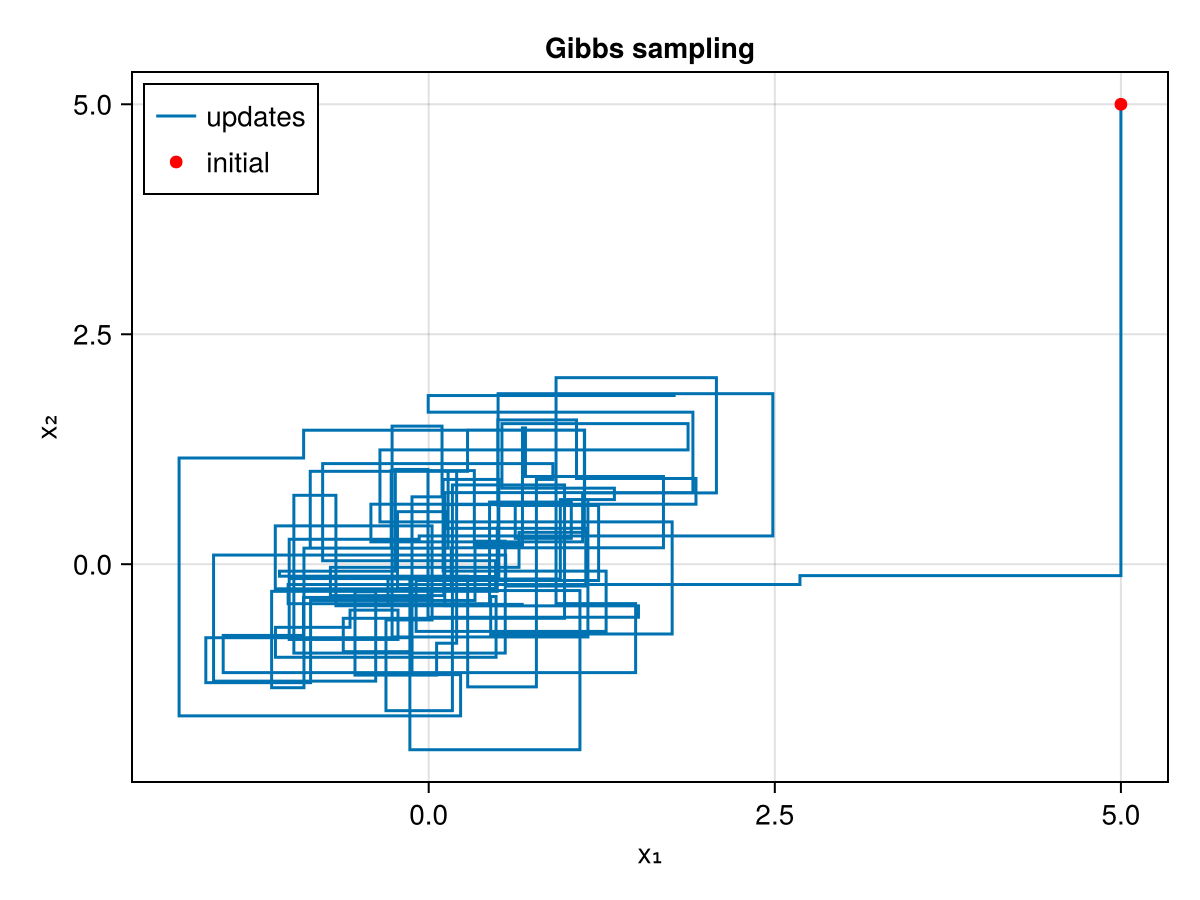

In [6]:
fig = stairs(samples[:, 1], samples[:, 2], label = "updates", axis = axis_args)
scatter!([initial[1]], [initial[2]], color = :red, label = "initial")
axislegend(position = :lt)
fig
# save("data/figures/06-gibbs-bivariate-burnin.png")

For several iterations.

In [7]:
initial = [5, 10]
samples = gibbs_binormal(0.5, 2000, initial)
samples = vcat(transpose(initial), samples)

2001×2 Matrix{Float64}:
  5.0        10.0
  4.92832     2.59255
  2.19257     0.553979
  0.836918    0.630222
 -1.08525    -2.21473
 -1.30037    -1.62797
 -0.453729    0.224569
 -1.72141    -0.745829
 -1.29155    -1.22508
  0.443797    0.869871
  ⋮          
  0.671207    1.18032
  1.11235     2.48436
  1.65499     0.261321
  2.38757     2.34134
  2.79547     0.36042
  0.31066     0.547504
  0.528481    1.35117
  0.163446    0.956329
 -0.0164852   0.59512

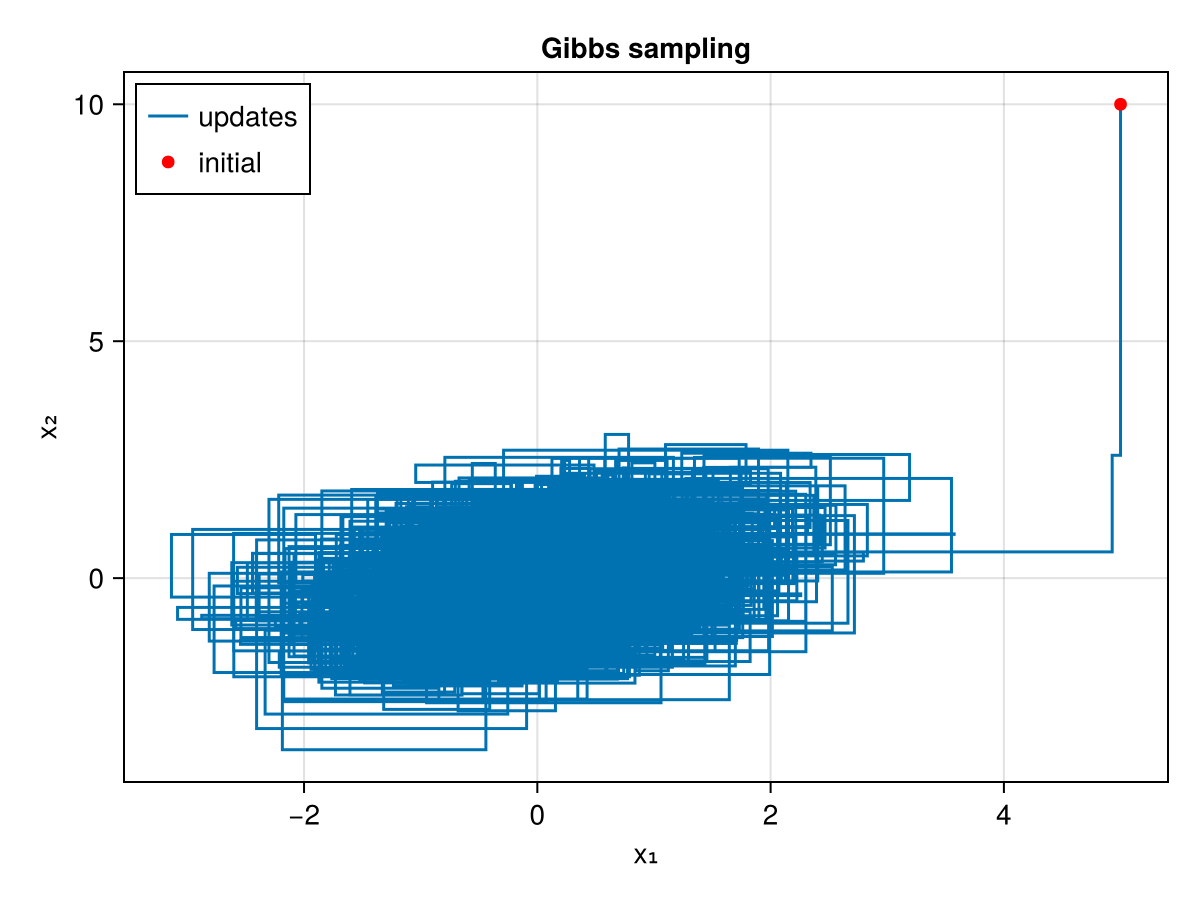

In [8]:
fig = stairs(samples[:, 1], samples[:, 2], label = "updates", axis = axis_args)
scatter!([initial[1]], [initial[2]], color = :red, label = "initial")
axislegend(position = :lt)
fig
# save("data/figures/06-gibbs-bivariate-burnin-2.png")

Samples from target distribution.

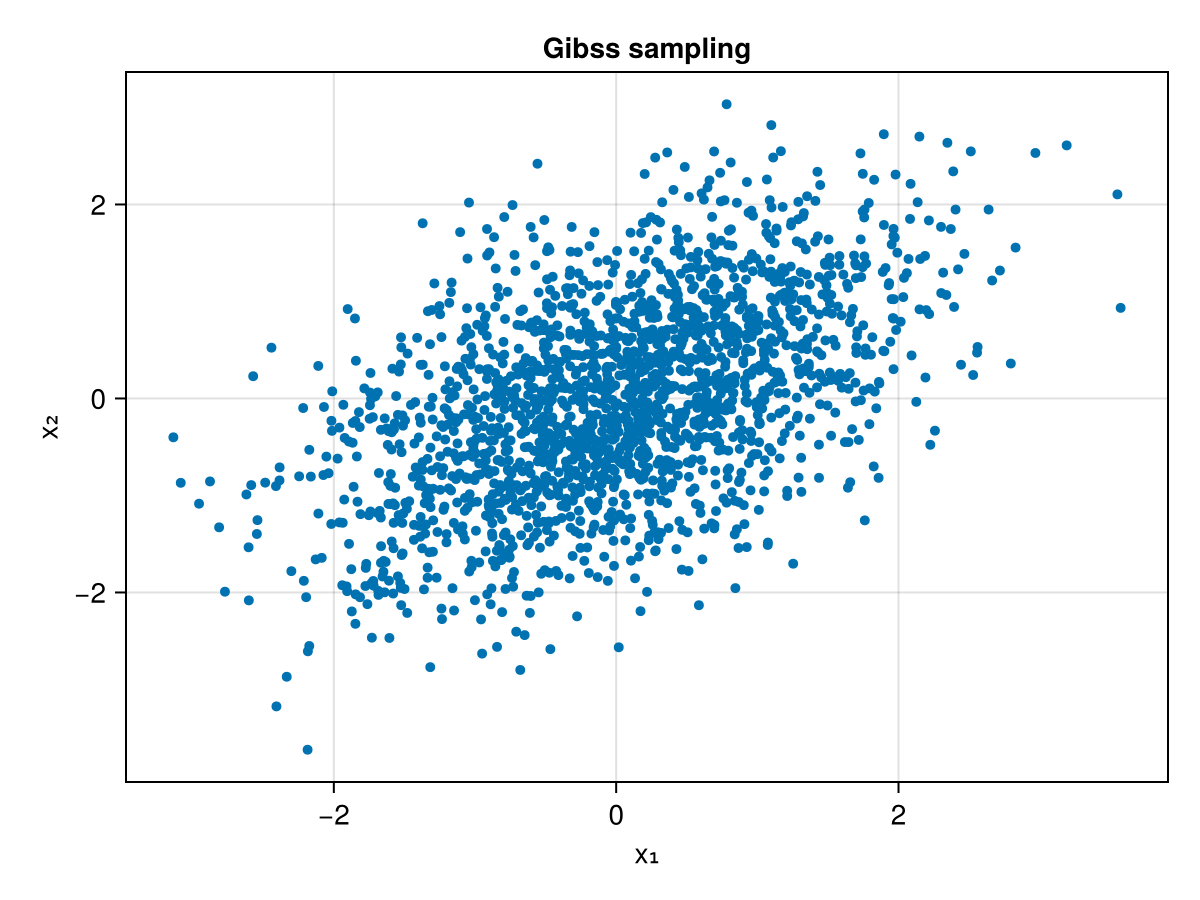

In [9]:
scatter(samples[10:end, 1], samples[10:end, 2], markersize = 7,
    axis = (title = "Gibss sampling", xlabel = "x₁", ylabel = "x₂"))

Marginal posterior distribution

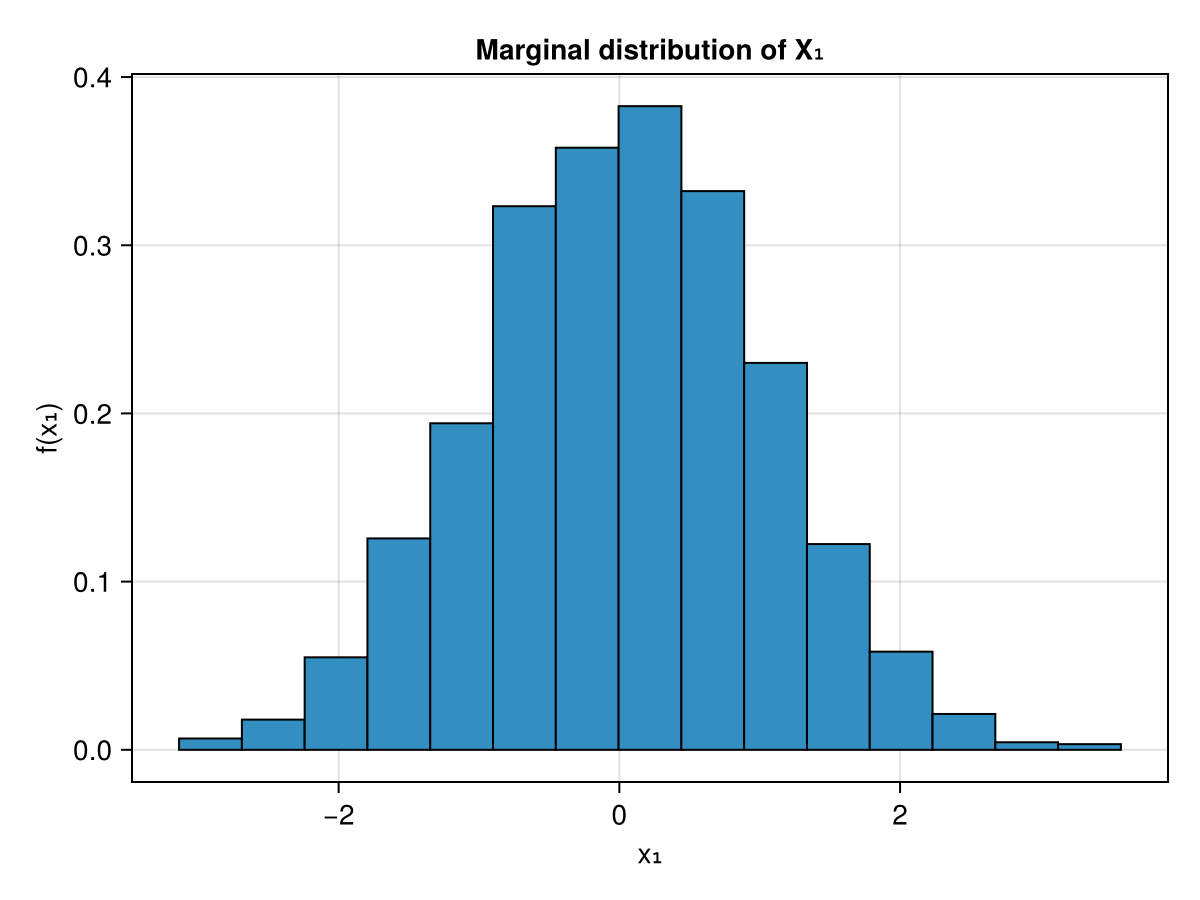

In [10]:
hist(samples[10:end, 1], normalization = :pdf, strokewidth = 1,
    axis = (title = "Marginal distribution of X₁", ylabel = "f(x₁)", xlabel = "x₁"))

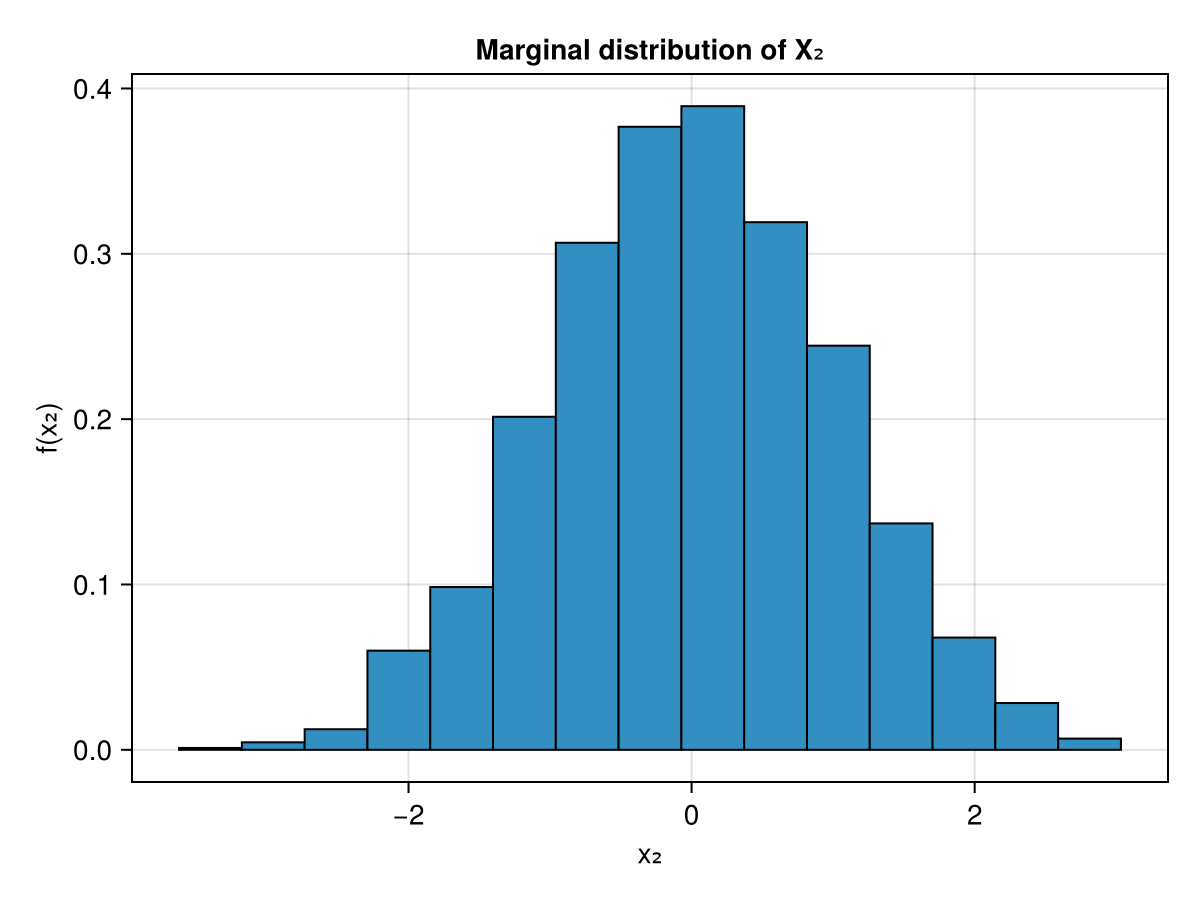

In [11]:
hist(samples[10:end, 2], normalization = :pdf, strokewidth = 1,
    axis = (title = "Marginal distribution of X₂", ylabel = "f(x₂)", xlabel = "x₂"))

##  Example for a Bayesian normal model

In [12]:
using Distributions
using CairoMakie
using Random

Simulate data.

In [13]:
μ = 10
σ² = 3
n = 300
X = Normal(μ, sqrt(σ²))
x = rand(X, n)

300-element Vector{Float64}:
 12.140737946510034
  8.571972776211123
  9.802141800023534
  9.86057357972735
  9.870084963380542
  6.701603512703151
 10.803778611411062
  9.24483295902616
  9.958118351255381
  9.10330088689646
  ⋮
 10.806825634544257
  9.593728513997721
  7.521803798701191
 11.81836450483579
 10.458839882845055
 10.81504757136092
 10.203794963163439
  9.046443081147507
  8.790935980482725

Custom function for Bayesian inference using Gibbs sampling.

In [14]:
function gibbs_normal(x::Vector, m::Int, initial::Vector;
    μ₀ = 0, σ²₀ = 1, a = 0.001, b = 0.001)
    n = length(x)
    x_mean = mean(x)
    samples = zeros(m, 2)

    # initial values
    μ = initial[1]
    σ² = initial[2]

    # conditional distributions
    for i = 1:m
        μ_mean = (μ₀* σ² + n * x_mean * σ²₀) / (σ² + n * σ²₀)
        μ_var = (σ² * σ²₀) / (σ² + n * σ²₀)
        μ = rand(Normal(μ_mean, sqrt(μ_var)))
        σ²_a = a + n / 2
        σ²_b = b + sum((x .- μ) .^ 2) / 2
        σ² = rand(InverseGamma(σ²_a, σ²_b))
        samples[i, :] = [μ, σ²]
    end

    return samples
end

gibbs_normal (generic function with 1 method)

### Visualize samples and true values

In [15]:
Random.seed!(7)
initial = [0, 1]
samples = gibbs_normal(x, 10000, initial, a = 1, b = 1.5)

10000×2 Matrix{Float64}:
  9.85959  2.79216
  9.9348   3.47005
  9.75844  3.05423
  9.84775  3.07087
 10.0539   3.72037
  9.7038   3.66576
  9.85958  3.39767
  9.96487  2.97613
  9.83458  3.35452
  9.69292  3.13215
  ⋮        
  9.88734  2.96881
  9.83192  3.5301
  9.94177  3.02331
  9.68037  2.91042
  9.77121  3.72147
  9.70562  3.55175
  9.8748   3.81088
  9.84527  3.31101
  9.91546  3.17835

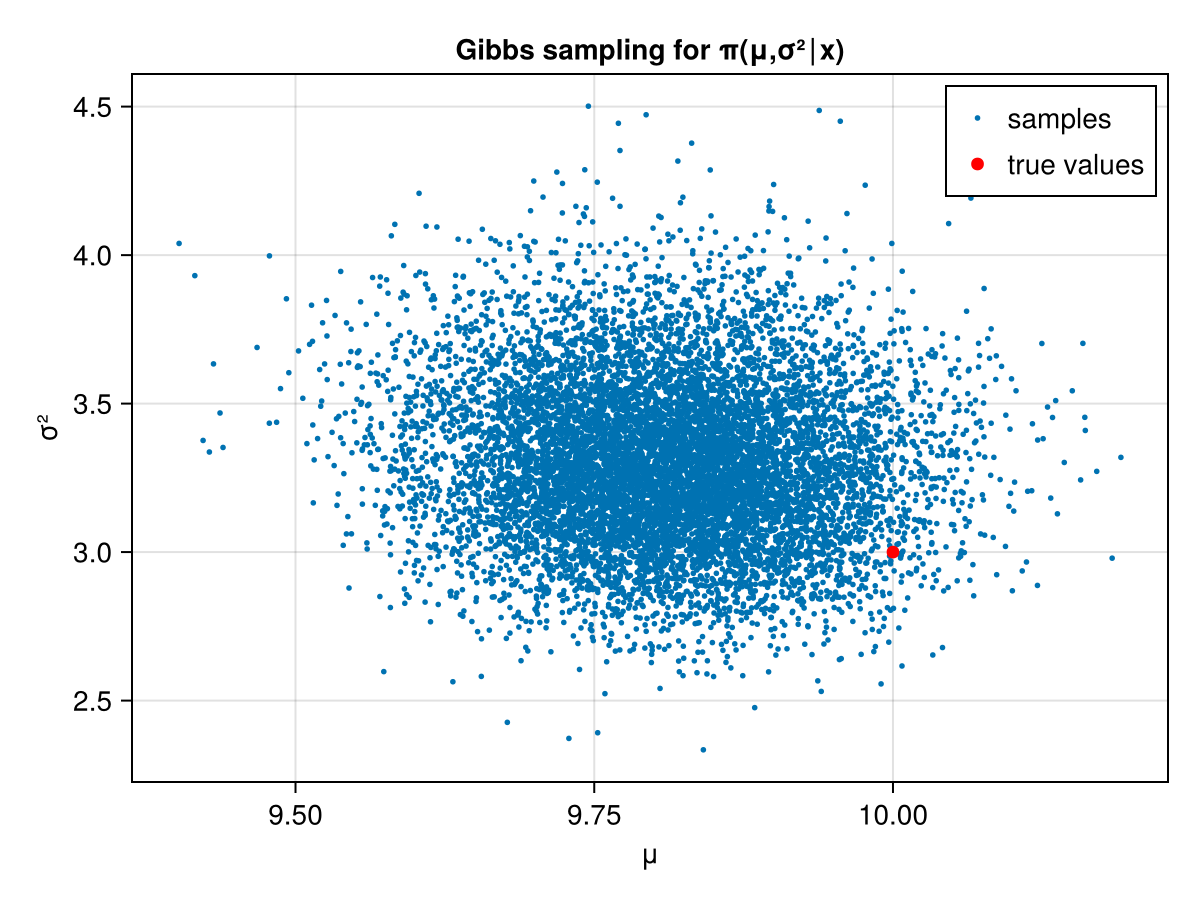

In [16]:
fig = scatter(samples[:, 1], samples[:, 2], markersize = 4, label = "samples",
    axis = (title = "Gibbs sampling for π(μ,σ²∣x)", xlabel = "μ", ylabel = "σ²"))
scatter!([μ], [σ²], color = :red, label = "true values")
axislegend()
fig

### Marginal posterior distributions

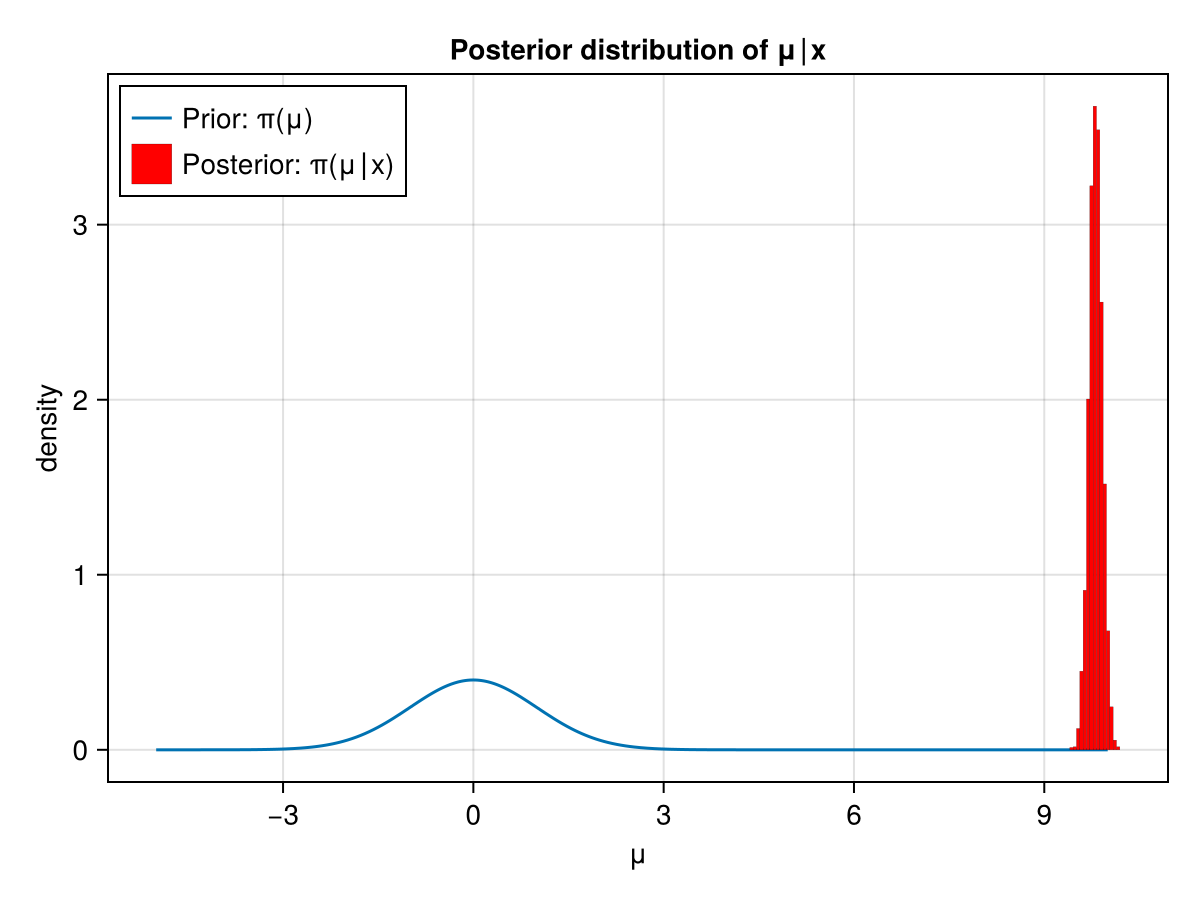

In [17]:
axis_arg = (title = "Posterior distribution of μ∣x", xlabel = "μ", ylabel = "density")
fig = lines(-5..10, x -> pdf(Normal(0, 1), x), label = "Prior: π(μ)", axis = axis_arg)
hist!(samples[:, 1], normalization = :pdf, strokewidth = 0.1, color = :red, label = "Posterior: π(μ∣x)")
axislegend(position = :lt)
fig

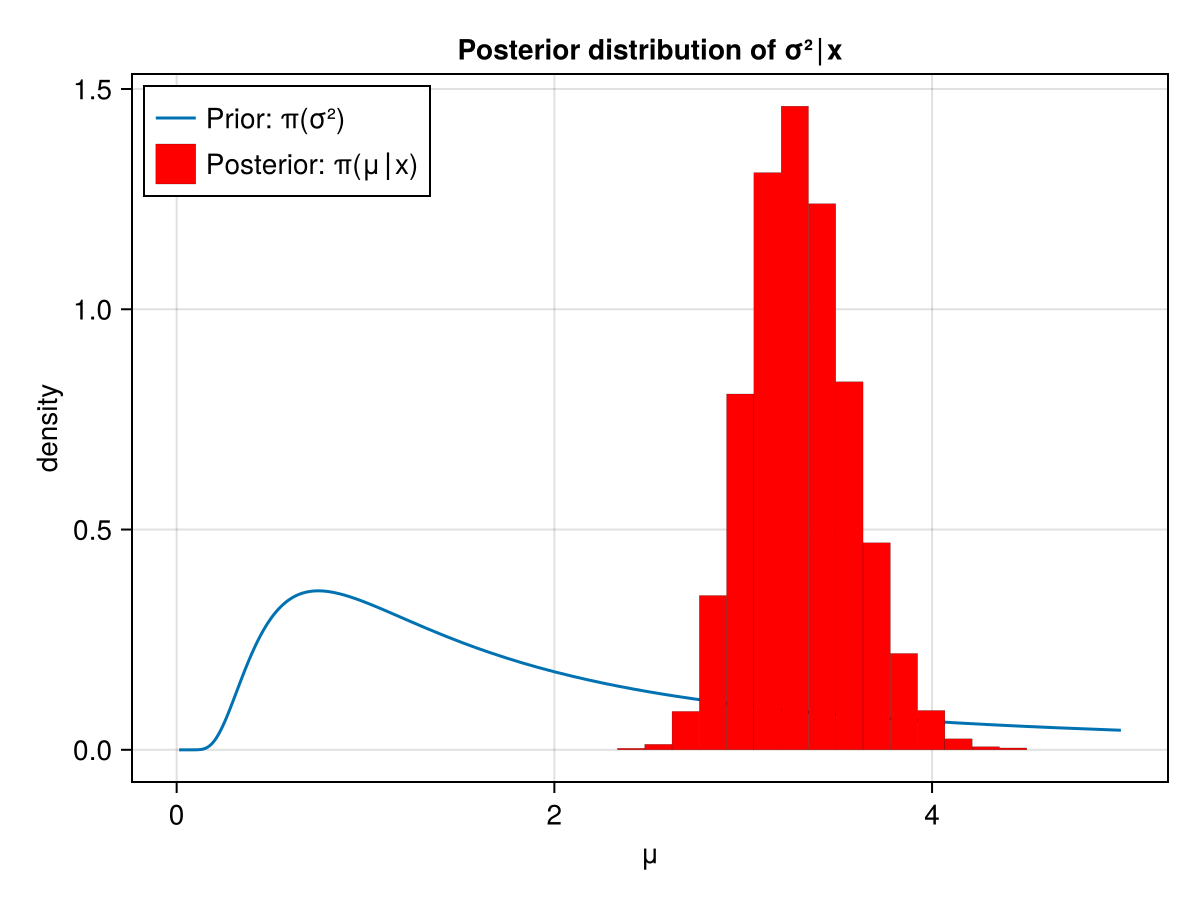

In [18]:
axis_arg = (title = "Posterior distribution of σ²∣x", xlabel = "μ", ylabel = "density")
fig = lines(0..5, x -> pdf(InverseGamma(1, 1.5), x), label = "Prior: π(σ²)", axis = axis_arg)
hist!(samples[:, 2], normalization = :pdf, strokewidth = 0.1, color = :red, label = "Posterior: π(μ∣x)")
axislegend(position = :lt)
fig

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*